# Setup

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [228]:
from pathlib import Path
from functools import partial
import sklearn

In [3]:
from fastai import *
from fastai.vision import *

In [4]:
bs = 96
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

# Load and Prepare Data

In [5]:
!pwd

/data/intsco/off-sample


In [6]:
gs_path = Path('./GS/raw_images'); gs_path

PosixPath('GS/raw_images')

In [7]:
row_list = []
for ds_path in gs_path.iterdir():
    for cl in ['on', 'off']:
        for p in (ds_path / cl).iterdir():
            row_list.append([str(p), ds_path.name, cl])

df = pd.DataFrame(row_list, columns=['name', 'group', 'label'])
df.shape

(22837, 3)

In [8]:
df.head()

,name,group,label
0,GS/raw_images/Tumor11/on/C45H76O7-H.png,Tumor11,on
1,GS/raw_images/Tumor11/on/C23H40O4+Cl.png,Tumor11,on
2,GS/raw_images/Tumor11/on/C42H80NO8P+Cl.png,Tumor11,on
3,GS/raw_images/Tumor11/on/C20H30O2-H.png,Tumor11,on
4,GS/raw_images/Tumor11/on/C6H12O3-H.png,Tumor11,on


In [49]:
from sklearn.model_selection import GroupKFold

In [52]:
# df['valid'] = [i in train_inds for i in df.index]

In [53]:
all_groups = list(df.group.unique())
print(len(all_groups))
valid_groups = ['S649 WS21 155x105 15um E110']
train_groups = [g for g in all_groups if g not in valid_groups]

86


In [54]:
len(train_groups), valid_groups

(85, ['S649 WS21 155x105 15um E110'])

# Resnet34 Experiments

In [59]:
cv = GroupKFold(n_splits=5)
train_inds, valid_inds = next(cv.split(df.group, groups=df.group))

In [252]:
set(df.group.iloc[train_inds].unique()) & set(df.group.iloc[valid_inds].unique())

set()

In [284]:
df.group.iloc[train_inds].unique().shape, df.group.iloc[valid_inds].unique().shape

((69,), (18,))

In [60]:
src = (ImageItemList.from_df(df, '', cols=0)
       .split_by_idxs(train_inds, valid_inds)
       .label_from_df(cols=2))

In [62]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [63]:
data = src.transform(tfms, size=128).databunch().normalize(imagenet_stats)

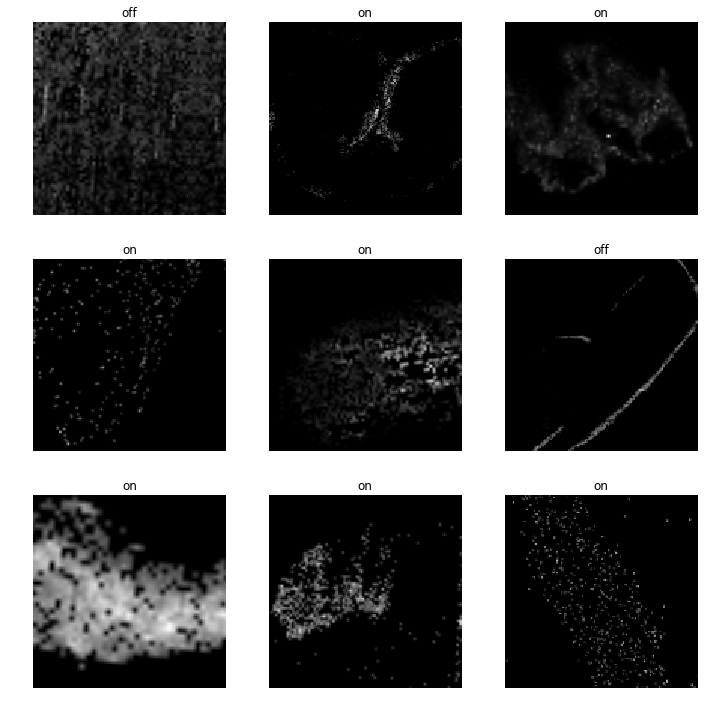

In [99]:
data.show_batch(rows=3, figsize=(10, 10))

In [71]:
f_score = partial(fbeta, thresh=0.5)

In [72]:
arch = models.resnet34

In [157]:
learn = create_cnn(data, arch, metrics=[accuracy])

In [158]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


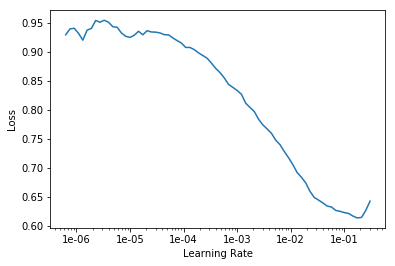

In [159]:
learn.recorder.plot()

In [166]:
lr = 1e-3 * 5
lr, np.log10(lr), 10**-2.3

(0.005, -2.3010299956639813, 0.005011872336272725)

In [161]:
learn.fit_one_cycle(5, slice(lr))

Total time: 04:42
epoch  train_loss  valid_loss  accuracy
1      0.228138    0.097923    0.964678  (00:56)
2      0.178165    0.076871    0.971479  (00:56)
3      0.152063    0.067669    0.976744  (00:56)
4      0.121016    0.067916    0.976305  (00:56)
5      0.112165    0.061960    0.976086  (00:56)



In [162]:
learn.save('gs-rn34-stage1.fai')

In [171]:
learn.load('gs-rn34-stage1.fai');

In [172]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


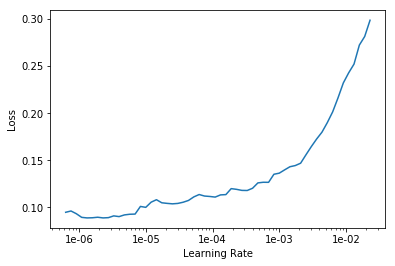

In [173]:
learn.lr_find(); learn.recorder.plot()

In [177]:
lr/10, np.log10(lr/10), 10**-3.3

(0.0005, -3.3010299956639813, 0.0005011872336272725)

In [178]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

Total time: 03:52
epoch  train_loss  valid_loss  accuracy
1      0.120766    0.059418    0.976964  (01:17)
2      0.116957    0.053744    0.980254  (01:17)
3      0.088617    0.051534    0.978499  (01:17)



In [179]:
learn.save('gs-rn34-stage2.fai')

In [180]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [181]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


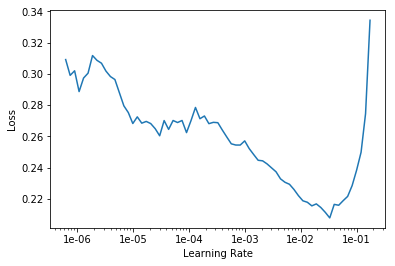

In [182]:
learn.lr_find(); learn.recorder.plot()

In [230]:
10**-2.3

0.005011872336272725

In [231]:
lr = 5e-3
lr

0.005

In [186]:
learn.fit_one_cycle(5, slice(lr))

Total time: 14:23
epoch  train_loss  valid_loss  accuracy
1      0.132621    0.059657    0.979596  (02:54)
2      0.125615    0.049617    0.980693  (02:51)
3      0.117428    0.042240    0.985739  (02:52)
4      0.095673    0.047205    0.982668  (02:52)
5      0.083394    0.044893    0.983984  (02:52)



In [232]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-5, lr/10))

Total time: 20:05
epoch  train_loss  valid_loss  accuracy
1      0.099603    0.086654    0.965116  (04:01)
2      0.095653    0.064610    0.975647  (04:01)
3      0.088380    0.057391    0.978061  (04:01)
4      0.076121    0.048145    0.982448  (04:00)
5      0.072112    0.049539    0.980693  (04:01)



### Metrics and Interpretation

In [246]:
from sklearn.metrics import f1_score, average_precision_score, precision_score, recall_score, accuracy_score

def convert_to_2dim(y):
    y_ = y
    if y.ndim < 2:
        y_ = np.zeros(shape=(y.shape[0], 2))
        y_[:,0] = 1 - y
        y_[:,1] = y
    return y_

def calc_metrics(y_true, y_pred):
    y_true = convert_to_2dim(y_true)
    y_pred = convert_to_2dim(y_pred)

    y_pred_lab = (y_pred > 0.5).astype(int)
    metrics = []
    classes = [(0, 'on'), (1, 'off')]
    for i, cl in classes:
        metrics.append(OrderedDict({
            'f1': f1_score(y_true[:,i], y_pred_lab[:,i]),
            'prec': precision_score(y_true[:,i], y_pred_lab[:,i]),
            'recall': recall_score(y_true[:,i], y_pred_lab[:,i]),
            'acc': accuracy_score(y_true[:,i], y_pred_lab[:,i]),
        }))
    return pd.DataFrame(metrics, index=['on', 'off'])

In [236]:
y_pred, y_true = learn.get_preds(ds_type=DatasetType.Valid)

In [247]:
calc_metrics(y_true.numpy(), y_pred.numpy())

,f1,prec,recall,acc
on,0.983070,0.978519,0.987664,0.980035
off,0.975675,0.982239,0.969198,0.980035


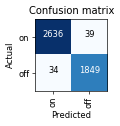

In [189]:
interp.plot_confusion_matrix(figsize=(2, 2), dpi=60)

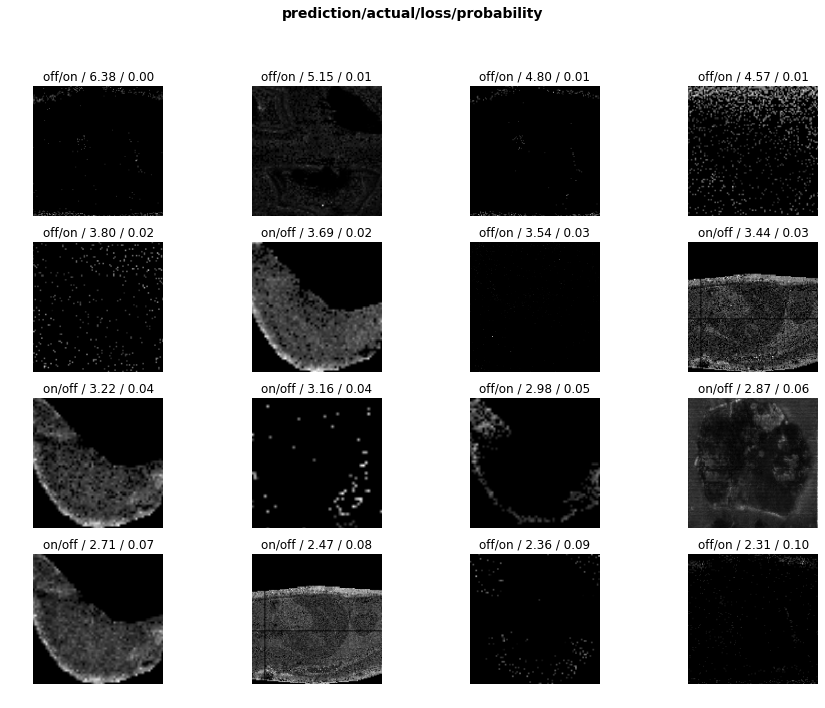

In [188]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(16, figsize=(15, 11))

In [286]:
# learn.model

# Cross Validation

In [260]:
# %%time
# utils = reload(utils)

break_after_first_fold = False
folds = 5  # number of CV folds
cv_metrics = []

image_df = df #.head(2000)

cv = GroupKFold(n_splits=folds)
for fold_i, (train_inds, test_inds) in enumerate(cv.split(image_df.group, groups=image_df.group)):
    print(f'Fold: {fold_i}', train_inds.shape, test_inds.shape)
    
    src = (ImageItemList.from_df(image_df, '', cols=0)
           .split_by_idxs(train_inds, valid_inds)
           .label_from_df(cols=2))
    tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
    arch = models.resnet34

    data = (src.transform(tfms, size=128)
            .databunch().normalize(imagenet_stats))
    learn = create_cnn(data, arch, metrics=[accuracy])

    print('First round: small images, head training')
    lr = 5e-3
    learn.fit_one_cycle(5, slice(lr))
#     learn.save('gs-rn34-stage1.fai')

    print('Second round: small images, fine-tuning')
    learn.unfreeze()
    learn.fit_one_cycle(5, slice(1e-5, lr/10))
#     learn.save('gs-rn34-stage2.fai')

#     print('Third round: resnet image size, head training')
#     data = (src.transform(tfms, size=224)  # "native" size for Resnet34
#             .databunch().normalize(imagenet_stats))
#     learn.data = data

#     lr = 5e-3
#     learn.fit_one_cycle(5, slice(lr))
#     learn.save('gs-rn34-stage3.fai')
    #learn.unfreeze()
    #learn.fit_one_cycle(5, slice(1e-5, lr/10))

    y_pred, y_true = learn.get_preds(ds_type=DatasetType.Valid)
    metrics = calc_metrics(y_true.numpy(), y_pred.numpy())
    metrics['fold'] = fold_i
    cv_metrics.append(metrics)
    print(metrics, end='\n\n')

metrics_df = pd.concat(cv_metrics)
metrics_df.to_msgpack('metrics_df.msgpack')

           f1      prec    recall       acc  fold
on   0.994772  0.993659  0.995888  0.993857     4
off  0.992553  0.994140  0.990972  0.993857     4



NameError: name 'history_list' is not defined

In [262]:
metrics_df.groupby(metrics_df.index).agg([np.mean, np.std])

f1                prec              recall                 acc  \
         mean       std      mean       std      mean       std      mean   
off  0.988241  0.006581  0.986273  0.008232  0.990228  0.005727  0.990259   
on   0.991685  0.004675  0.993100  0.004056  0.990280  0.005857  0.990259   

              fold            
          std mean       std  
off  0.005466    2  1.581139  
on   0.005466    2  1.581139

In [263]:
metrics_df

,f1,prec,recall,acc,fold
on,0.983508,0.986095,0.980935,0.980693,0
off,0.976720,0.973115,0.980351,0.980693,0
on,0.994019,0.994019,0.994019,0.992979,1
off,0.991503,0.991503,0.991503,0.992979,1
on,0.994005,0.996245,0.991776,0.992979,2
off,0.991530,0.988391,0.994689,0.992979,2
on,0.992123,0.995484,0.988785,0.990785,3
off,0.988901,0.984219,0.993627,0.990785,3
on,0.994772,0.993659,0.995888,0.993857,4
off,0.992553,0.994140,0.990972,0.993857,4


In [264]:
interp = ClassificationInterpretation.from_learner(learn)

In [265]:
interp.confusion_matrix()

array([[2664,   11],
       [  17, 1866]])

---